In [1]:
from pathlib import Path
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import torch.optim as optim
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *
from cmd_classes_funcs_Marchese import *

/home/CAMPUS/cemb2020/anaconda3/envs/arcslab/lib/python3.8/site-packages/fastbook/__init__.py:18: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [2]:
# Make sure we're running on the server's GPU
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=3)

In [3]:
# Get classes and filenames
path = Path("data")
classes = get_class_labels(path)
all_filenames = get_filenames(path)

## Splitting Data into train/validate sets

In [4]:
# Getting size of dataset and corresponding list of indices
dataset_size = len(all_filenames)
dataset_indices = list(range(dataset_size))

In [5]:
# Shuffling the indices
np.random.shuffle(dataset_indices)

In [6]:
# Getting index for where we want to split the data
val_split_index = int(np.floor(0.2 * dataset_size))

In [7]:
# Splitting list of indices into training and validation indices
train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]

In [8]:
# Creating samplers
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [9]:
# Getting list of filenames for training and validation set
train_filenames = [all_filenames[i] for i in train_idx]
val_filenames = [all_filenames[i] for i in val_idx]

In [10]:
# Create training and validation datasets
train_data = ImageWithCmdDataset(classes, train_filenames)
val_data = ImageWithCmdDataset(classes, val_filenames)

In [11]:
train_loader = DataLoader(dataset=train_data, shuffle=False, batch_size=16, sampler=train_sampler)
val_loader = DataLoader(dataset=val_data, shuffle=False, batch_size=16, sampler=val_sampler)

In [12]:
# Instantiate MyModel class
net = MyModel_next50()

In [13]:
# Send model to GPU
net.to(device)

MyModel_next50(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [14]:
n = dataset_size
w = torch.tensor([(n-138)/n,(n-211)/n,(n-786)/n])
w = w.to(device)
# defining loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=w)
optimizer = optim.Adam(net.parameters(), lr=.0001) # .0000015

In [15]:
num_epochs = 70

In [16]:
from time import time

In [17]:
# Model training

net.train()

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    
    start = time()
    
    for data in train_loader:
        # Get the inputs and labels
        inp_data, label = data
        
        # Break up the inputs
        img, cmd = inp_data
        
        # Putting data into the GPU
        img = img.to(device)
        cmd = cmd.to(device)
        label = label.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        output = net((img, cmd))
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    print(f"Epoch:{epoch+1:}/{num_epochs}, Training Loss:{running_loss:0.1f}, Time:{time()-start:0.1f}s")

print('Finished Training')

Epoch:1/70, Training Loss:185.2, Time:80.7s
Epoch:2/70, Training Loss:122.7, Time:80.3s
Epoch:3/70, Training Loss:91.5, Time:81.0s
Epoch:4/70, Training Loss:65.9, Time:80.9s
Epoch:5/70, Training Loss:48.5, Time:80.6s
Epoch:6/70, Training Loss:40.7, Time:79.7s
Epoch:7/70, Training Loss:29.3, Time:78.3s
Epoch:8/70, Training Loss:29.2, Time:79.4s
Epoch:9/70, Training Loss:33.0, Time:78.7s
Epoch:10/70, Training Loss:30.0, Time:78.2s
Epoch:11/70, Training Loss:18.3, Time:78.7s
Epoch:12/70, Training Loss:21.7, Time:79.0s
Epoch:13/70, Training Loss:19.1, Time:78.6s
Epoch:14/70, Training Loss:14.3, Time:78.8s
Epoch:15/70, Training Loss:13.8, Time:79.1s
Epoch:16/70, Training Loss:11.8, Time:79.2s
Epoch:17/70, Training Loss:18.4, Time:79.4s
Epoch:18/70, Training Loss:12.5, Time:78.4s
Epoch:19/70, Training Loss:8.1, Time:78.5s
Epoch:20/70, Training Loss:6.5, Time:79.3s
Epoch:21/70, Training Loss:11.1, Time:78.7s
Epoch:22/70, Training Loss:17.8, Time:78.6s
Epoch:23/70, Training Loss:12.8, Time:79.

In [18]:
# Checking accuracy on validation set

correct = 0
total = 0

# Variables to keep track of accuracy for each class
class_correct = [0 for _ in classes]
class_total = [0 for _ in classes]

net.eval()

with torch.no_grad():

    for data in val_loader:

        # Get the inputs and label data
        inp_data, label = data
        
        # Break up the inputs
        img, cmd = inp_data
        
        # Putting data into the GPU
        img = img.to(device)
        cmd = cmd.to(device)
        label = label.to(device)


        # Predict
        output = net((img, cmd))
        
        # Assuming we always get batches
        for i in range(output.size()[0]):
                
            # Getting the predicted most probable move
            move = torch.argmax(output[i])
                
            if move == label[i]:
                class_correct[label[i]] += 1
                class_total[label[i]] += 1
                correct +=1
            else:
                class_total[label[i]] += 1
            total += 1
        
# Calculate and output total set accuracy 
accuracy = correct / total
print(f"Accuracy on validation set: {correct}/{total} = {accuracy*100:.2f}%")

# Calculate and show accuracy for each class
for i, cls in enumerate(classes):
    ccorrect = class_correct[i]
    ctotal = class_total[i]
    caccuracy = ccorrect / ctotal
    print(f"  Accuracy on {cls:>5} class: {ccorrect}/{ctotal} = {caccuracy*100:.2f}%")

Accuracy on validation set: 1292/1399 = 92.35%
  Accuracy on  left class: 196/227 = 86.34%
  Accuracy on right class: 202/243 = 83.13%
  Accuracy on straight class: 894/929 = 96.23%


In [19]:
PATH = 'cmd_torch_next50.pth'
torch.save(net.state_dict(), PATH)

In [20]:
data, labels = next(iter(val_loader))
labels.shape

torch.Size([16])

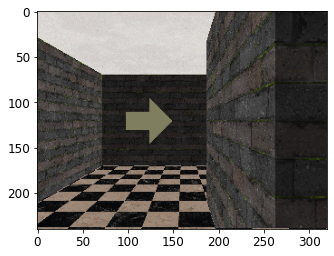

In [21]:
plt.imshow(data[0][0].permute(1,2,0))

In [22]:
labels[0]

tensor(2)

In [23]:
net.eval()
img = data[0][0]
cmd = data[1][0]
img = img.to(device)
cmd = cmd.to(device)
net((img.unsqueeze(0), cmd.unsqueeze(0)))

tensor([[-1.0849, -3.6399,  4.1131]], device='cuda:3', grad_fn=<AddmmBackward>)